In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.io import fits

We first have to start defining the model itself. Let's start by writing down our function.

We jus saw in class that M-E assumption, where line profile is constant with depth looks like: 
$$I_\lambda = S_0 + \frac{S_1}{1+\eta \phi_\lambda(\lambda_0,\sigma,a)} $$

Where $S_0$ and $S_1$ determine the depth dependence of the source function, $\eta$ is line-to-continuum opacity ratio, $\lambda_0$ is line center position, $\sigma$ Doppler width and $a$ is the damping.

In [3]:
# Let's start with the profile, which is the most tricky part of the game:
# This piece of code show how to calculate the Voigt profile, which is an essential 
# part of the M-E inversion.

from scipy.special import wofz

# This is the original formulation of Voigt function, by using wofz
def V(x, alpha, gamma):
    
    #Return the Voigt line shape at x with Lorentzian component HWHM gamma
    #and Gaussian component HWHM alpha.

    sigma = alpha / np.sqrt(2 * np.log(2))

    return np.real(wofz((x + 1j*gamma)/sigma/np.sqrt(2))) / sigma /np.sqrt(2*np.pi)

# This is a formulation where we "normalize" the wavelengths in order to get a dimensionless
# wavelength. It should work either way...

def voigt(center,doppler,damp,ll):
    
    xx = (ll - center)/doppler
    return V(xx,1.0,damp)

In [4]:
# Now let's define our model. Model takes the parameters p, that are going to change from 
# example to example, and wavleengths ll, that are going to stay the same. 

# These are hard-coded for 6301 line

def me_scalar(p,ll):
    
    # we have 6 parameters:
    S0 ,S1, eta, shift, width, damping = p
    
    # Note that we have here replaced the line center position with "shift", se below:
    center = 6301.49 * (1.+shift/2.997E5)
    
    # Also, let's assume width was also provided in km/s. Here we transform it to wavle 
    width *= 6301.49/2.997E5
    
    
    profile = voigt(center,width,damping,ll)
    
    return S0 + S1/(1.+profile*eta)

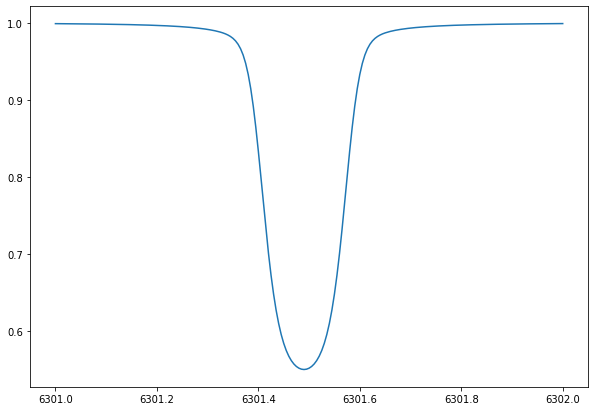

In [5]:
# Let's see if it works
S0 = 0.5
S1 = 0.5
eta = 20.0
shift = 0.0
width = 2.0 
damping = 0.05
ll = np.linspace(6301.,6302.,201)

spec = me_scalar([S0,S1,eta,shift,width,damping],ll)

plt.figure(figsize=[10,7])
plt.plot(ll,spec)


Looks good! Now time to experiment with some parameters. Let's first consider something that we all feel should be important line strength.

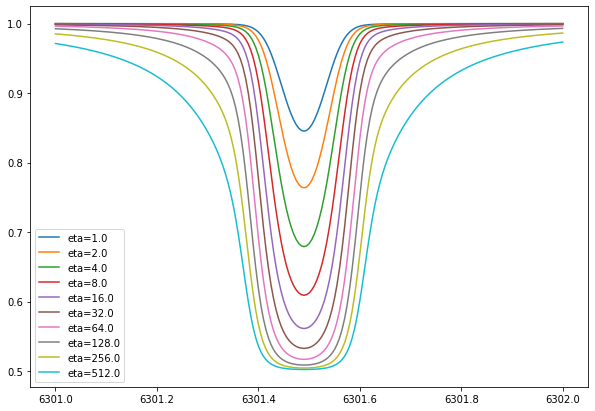

In [6]:
etavar = 1.0

plt.figure(figsize=[10,7])

for i in range(0,10):
    spec = me_scalar([S0,S1,etavar,shift,width,damping],ll)
    plt.plot(ll,spec,label='eta='+str(etavar))
    etavar *= 2.0

plt.legend()

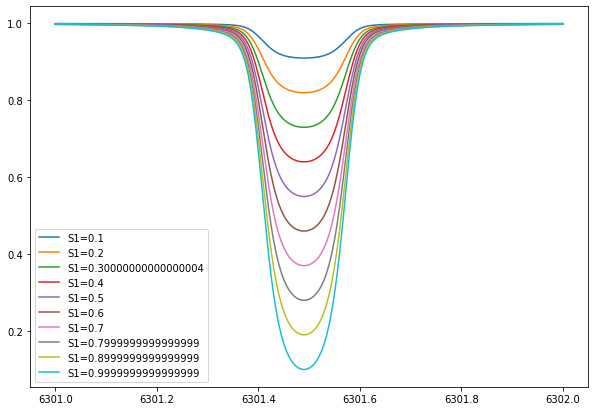

In [7]:
#Now the slope of the source functionbrew install eigen
S1var = 0.1

plt.figure(figsize=[10,7])

for i in range(0,10):
    spec = me_scalar([1.0-S1var,S1var,eta,shift,width,damping],ll)
    plt.plot(ll,spec,label='S1='+str(S1var))
    S1var += 0.1

plt.legend()

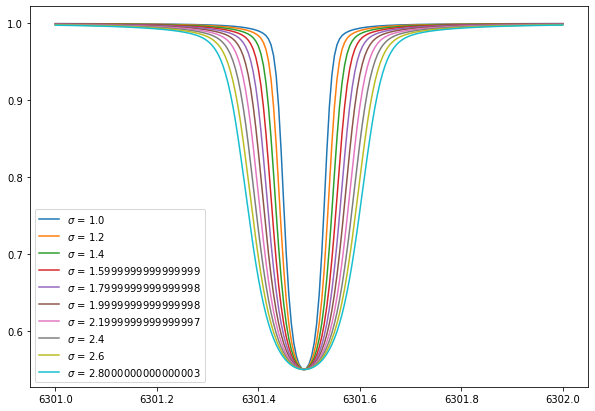

In [8]:
# And now the width
widthvar = 1.0 # in km/s

plt.figure(figsize=[10,7])

for i in range(0,10):
    spec = me_scalar([S0,S1,eta,shift,widthvar,damping],ll)
    plt.plot(ll,spec,label='$\sigma$ = '+str(widthvar))
    widthvar += 0.2

plt.legend()

In [9]:
# Now let's move to the data:

# Let's first look at the data.


stokes = fits.open("/home/milic/data/Hinode_network/hinode_network_c.fits")[0].data
stokes.shape

(512, 873, 4, 112)

In [10]:
stokes.shape
stokes /= np.mean(stokes[:,:,0,:10])

In [11]:
# Let's also assign wavelengths:
ll = np.linspace(0,111,112)
ll = 6302.08 + (ll-56.5)*0.0215

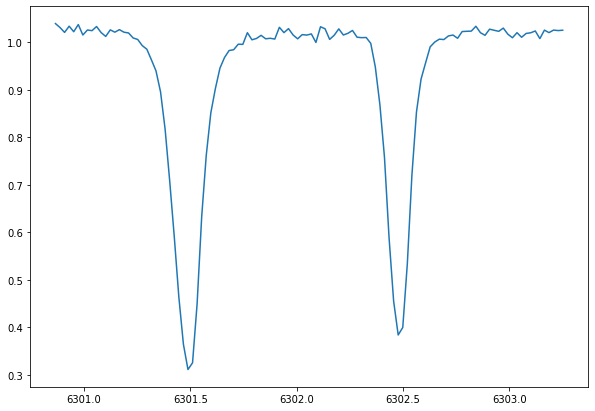

In [12]:
# Plot one spectrum:
plt.figure(figsize=[10,7])
plt.plot(ll,stokes[100,100,0,:])

In [13]:
#let's try now scipy.optimize.minimize

def chi2(params, x, y, error):
    
    #x is ll
    #y are the observed stokes 
    #uncertanties in y
    
    y_model = me_scalar(params,x)
    
    chi2 = np.sum(((y_model - y) / error)**2)
    
    return chi2

[-2.42707447  3.46015486  0.99537334 -0.13326115  2.25075517  0.71814757]
123.00457574924285


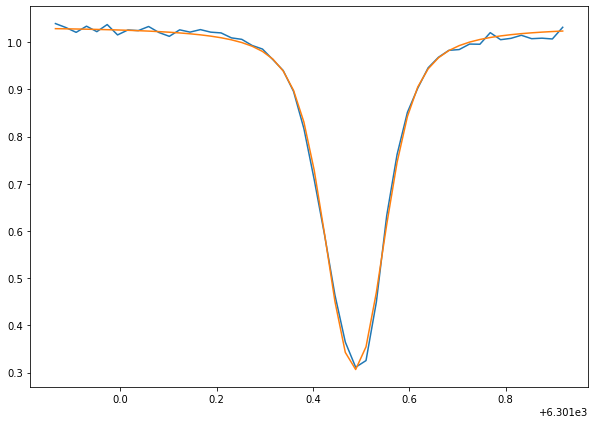

In [22]:
# Break the below code in a few steps:

from scipy.optimize import minimize
x_data = ll[:50]
y_data = stokes[100,100,0,:50]
errors = 1E-3

starting_params=[0.6,0.4,70.0,0.0,2.0,0.05]

result = minimize(chi2,starting_params,args=(x_data,y_data,errors))
print (result.x)

print (chi2(result.x,x_data,y_data,errors)/(50.-6.))
plt.figure(figsize=[10,7])
plt.plot(x_data,y_data)
plt.plot(x_data,me_scalar(result.x,x_data))

    

[ 0.2         0.84004566 20.49633794 -0.14312063  1.30473268  0.62935903]
159.51849244629446


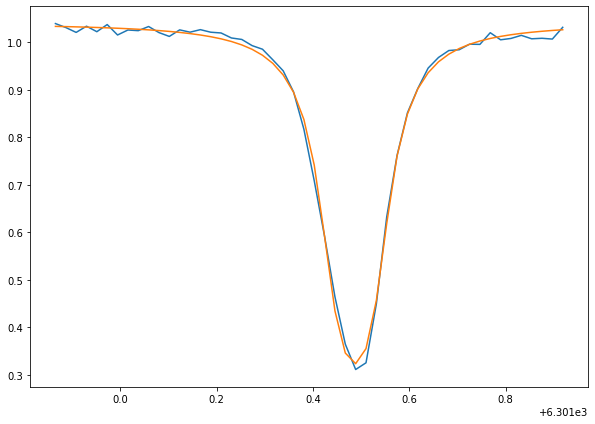

In [24]:
# Now the same but with the bounds:

from scipy.optimize import minimize
x_data = ll[:50]
y_data = stokes[100,100,0,:50]
errors = 1E-3

starting_params=[0.6,0.4,70.0,0.0,2.0,0.05]

result = minimize(chi2,starting_params,args=(x_data,y_data,errors),bounds=[(0.2,0.4),(0.0,1.0),(1.,100.),(-20,20),(0.5,5.0),(0,1)])
print (result.x)
print (chi2(result.x,x_data,y_data,errors)/(50.-6.))
plt.figure(figsize=[10,7])
plt.plot(x_data,y_data)
plt.plot(x_data,me_scalar(result.x,x_data))

    